# Business Case 1

## Wonderful Wine of the World

Wonderful Wines of the World (WWW) is a 7-year-old enterprise that seeks out small, unique wineries around the world and brings their wines to its customers. Its mission is to delight its customers with well-made, unique, and interesting wines that would never travel far beyond their points of origin.

For more informations about the business context, the report is available.

The objectives of this analysis are mainly 2 :
- profiling groups of customers
- identifying an appropriate marketing campaign

<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing data and libraries](#1)   
2.	[Exploratory data analysis (EDA)](#2)       
3.	[Data preprocessing](#3)  
4.  [Cluster analysis](#4)      
5.  [Merging the results](#5)

# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [108]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from joblib import dump

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

#Visualization
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from sklearn import random_projection

#sompy
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# profiling
from pandas_profiling import ProfileReport
# plotly
import plotly.graph_objects as go # We are only importing the 'graph_objects' module from plotly here
import psutil 
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

PROJECT_ROOT = Path(os.path.abspath('')).resolve()
#warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_excel('data/WonderfulWinesoftheWorld.xlsx')

In [5]:
data.set_index(keys=['Custid'],inplace=True)

In [6]:
cat_feats = ['Kidhome', 'Teenhome', 'SMRack', 'LGRack','Humid', 'Spcork', 'Bucket','Access','Complain', 'Mailfriend', 'Emailfriend']
numeric_feats = data.columns[~data.columns.isin(cat_feats)]

# 2. Exploratory data analysis (EDA) <a class="anchor" id="2"></a>

In [7]:
#find features with correlations greater than 0.9 in order to remove them
def correlation_check(df, limit = 0.90, drop = False):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    corr_no_diag = corr.where(mask)
    coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]        
    #df.drop(coll,axis = 1,inplace=True)
    print('High correlation columns are:', coll)
def corrheatmap(dataframe):
    sns.set(style="whitegrid")
    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)
    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

def boxplot_withoutLabels(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(y=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)

    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def displot_all(df, columns):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.histplot(x=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Dist plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def countplot_all(df, columns):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.countplot(x=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Count plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe, method = "pearson"):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr(method= method) #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True,annot=True, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0, fontsize = 14)
    plt.xticks(rotation=-45, fontsize = 14)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()        

## Check for variables univariate distribution

### Numeric features

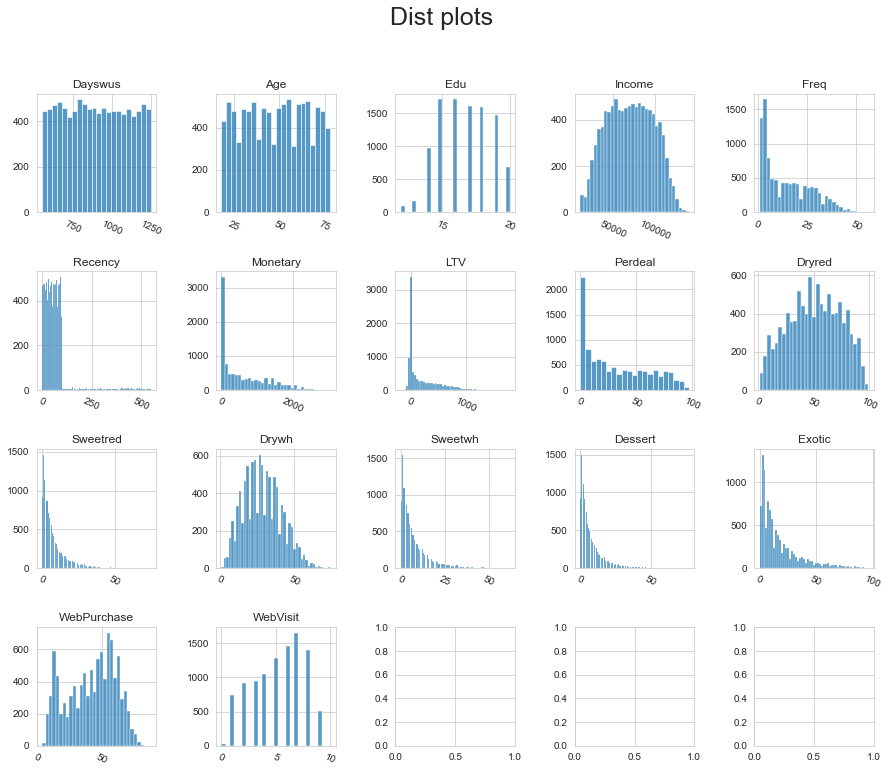

In [8]:
displot_all(data,numeric_feats)  

From the distribution plots of numerical variables, we are able to come to some analysis:
- Some features are highly skewed with long tail and potentially having outliers: `Recency`, `Monetary`, `LTV`, `Sweetred`, `Dessert`, `Exotic`
- Features maybe need need normality transformation due to high variance: `Monetary`, `LTV`

Let's see the box plots to validate our analysis 

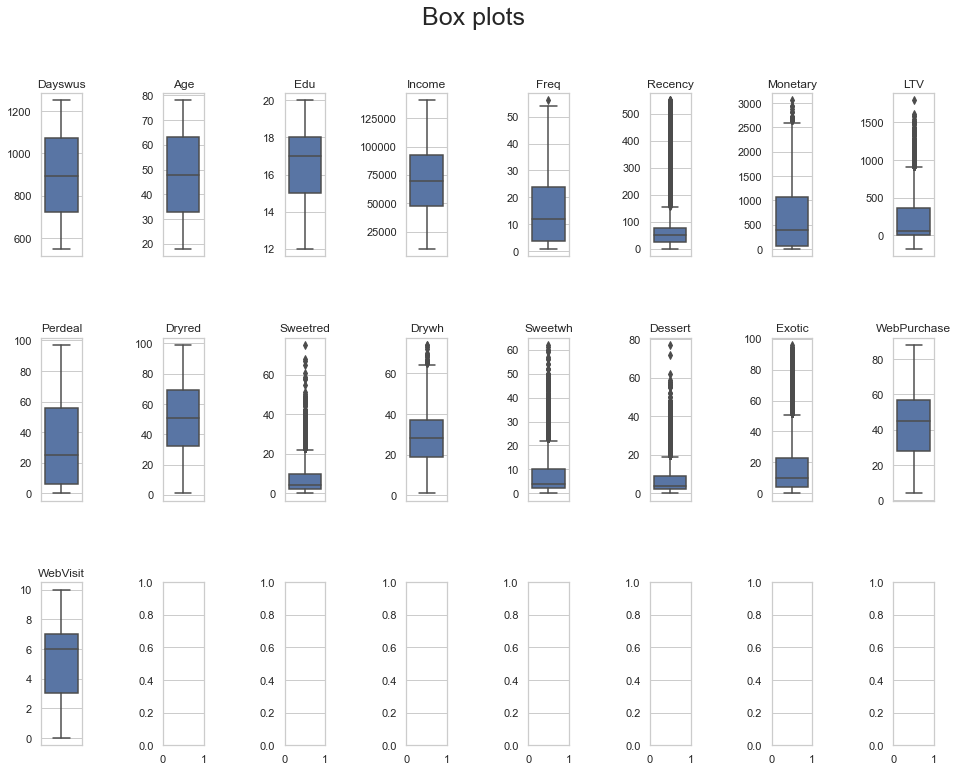

In [9]:
boxplot_withoutLabels(data[numeric_feats])

### Categorical features

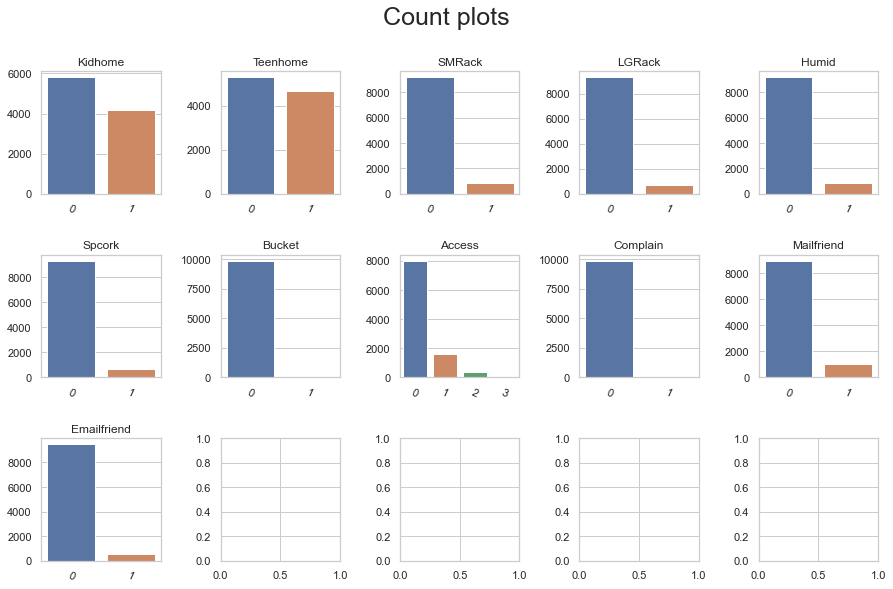

In [11]:
countplot_all(data,np.array(cat_feats))

#### Notations:
- 10 of them is binary features
- Clearly observerable that `Bucket` and `Complain` is very low in information gain, with close to 0 variation

## Check for missing values:

In [11]:
data.isna().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Kidhome        0
Teenhome       0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
SMRack         0
LGRack         0
Humid          0
Spcork         0
Bucket         0
Access         0
Complain       0
Mailfriend     0
Emailfriend    0
dtype: int64

Great news, no missing data at all!

## Checking duplicated observations

In [13]:
# Checking duplicated observations
data.loc[data.duplicated(keep=False), :]

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Kidhome, Teenhome, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit, SMRack, LGRack, Humid, Spcork, Bucket, Access, Complain, Mailfriend, Emailfriend]
Index: []

[0 rows x 28 columns]

### Notations
- The dataset contains 10000 customers and 29 variables. One of the variables, Custid, has been setted as the index of the dataset, unique identifier for each observations.
- The variables contain informations about the customers characteristics, the history of the wine-purchased and the type of wines that interest the customers.
- The dataset doesn't contain missing values, and neither duplicated rows.
- The 28 varaibles are all numerical, even though some of them are ratios and others are just binary. Other variables are expressed in percentages. A normalization for the different scales of the values of the features is needed.

## Check for multivariate corellation

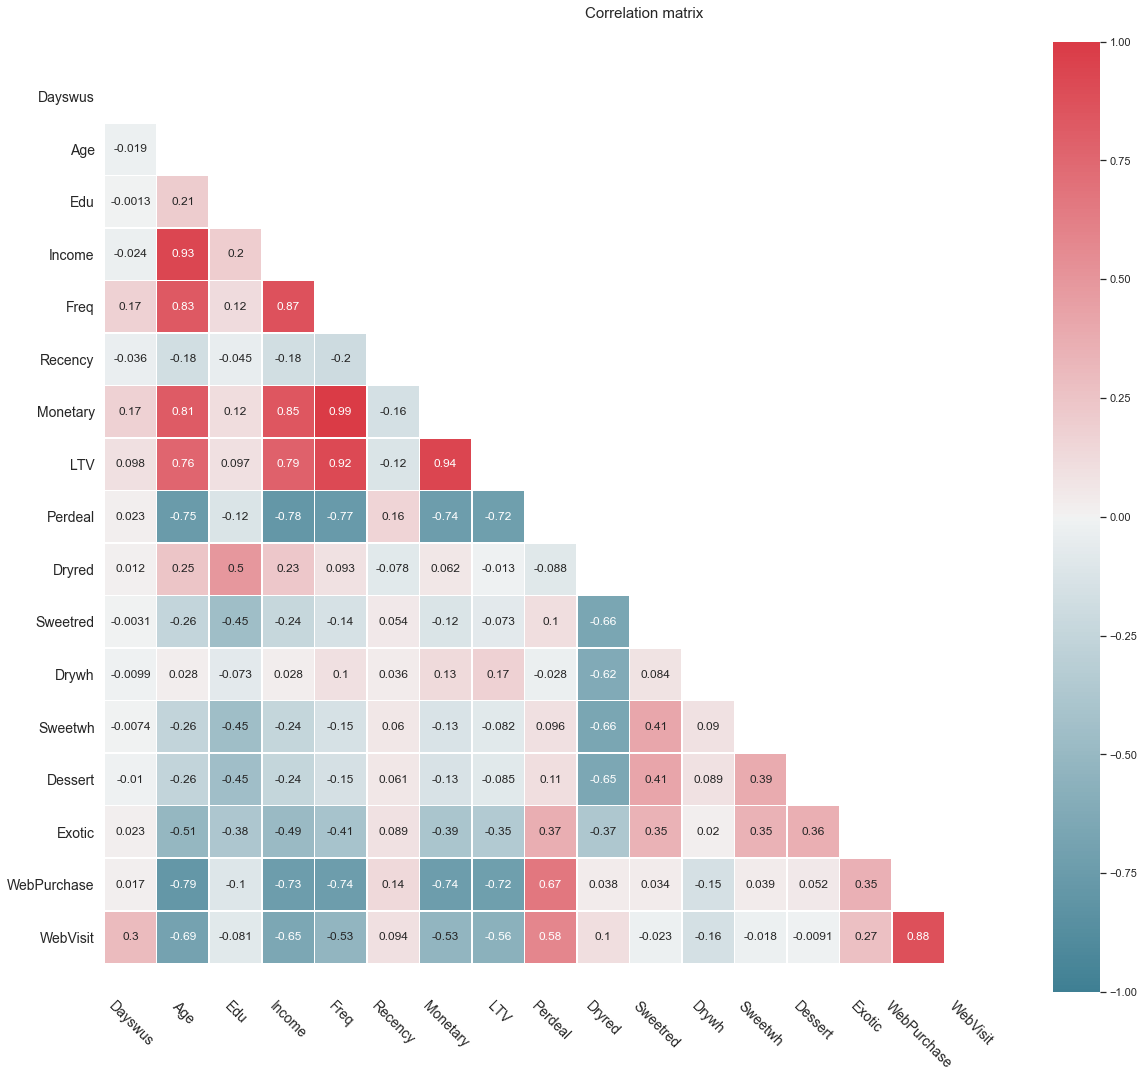

In [10]:
corrheatmap(data[numeric_feats], method = 'pearson')

- We can notice a high correlation between some pairs of variables, in particular the 2 highest percentage are the correlations between `Income` - `Age` and `Monetary` - `Freq`.
- We will analyse further `Monetary` - `Freq`, while in our opinion `Income` - `Age` can be both important for the cluster analysis we will compute afterwards, thus we keep these 2 variables in the dataset.

# 3. Data preprocessing <a class="anchor" id="3"></a>

### Feature Engineering

We will create new feature called Average amount perpurchase of each customer by dividing the Monetary by the Frequency value

`Avr_purchase` = `Monetary` / `Freq`

In [53]:
data['Avr_purchase'] = data['Monetary'] / data['Freq']

### Data Transformation

In [54]:
# Define numeric and categorical features after feature engineering
cat_feats = ['Kidhome', 'Teenhome', 'SMRack', 'LGRack','Humid', 'Spcork', 'Bucket','Complain', 'Mailfriend', 'Emailfriend', 'Access']
numeric_feats = data.columns[~data.columns.isin(cat_feats)]

In [52]:
# Box-cox transformation
def box_cox(data, columns):
    t_boxcox = PowerTransformer(method='box-cox')
    data[columns] = pd.DataFrame(t_boxcox.fit_transform(data[columns]+1), columns=columns,index = data.index)
    return data

In [55]:
transform_feats = numeric_feats[~numeric_feats.isin(['LTV','Access'])]

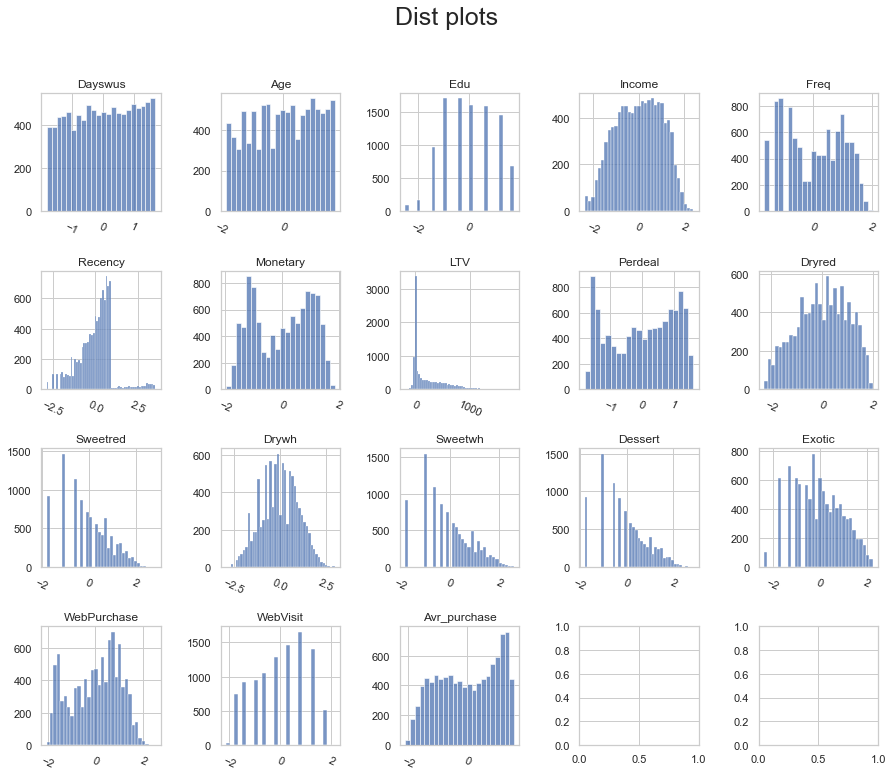

In [56]:
displot_all(box_cox(data[numeric_feats],transform_feats), numeric_feats)

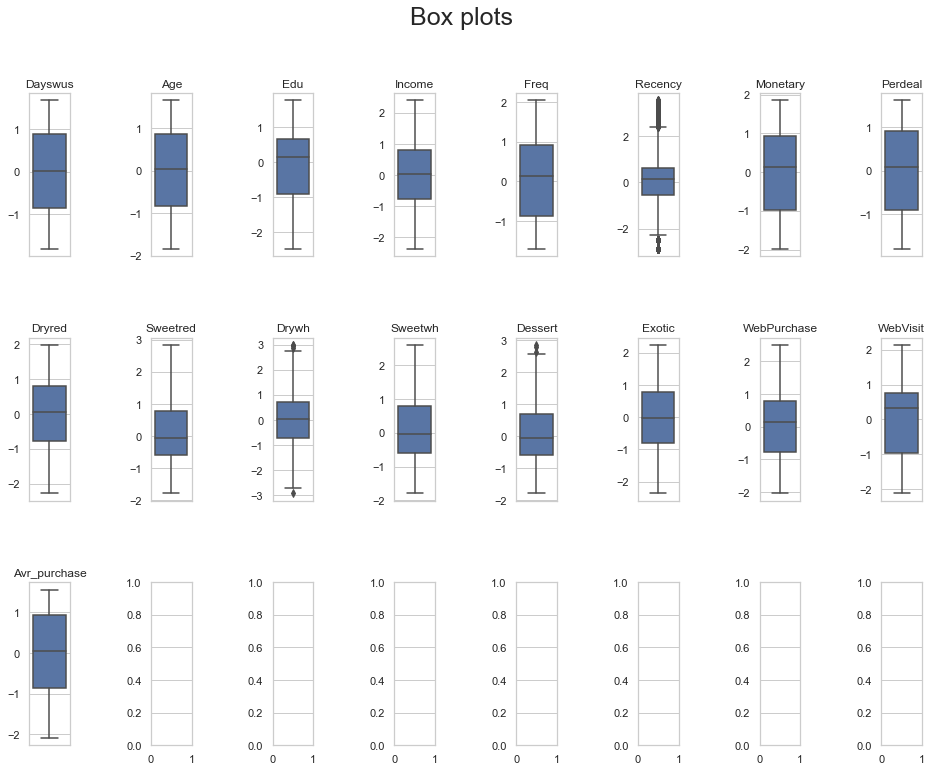

In [57]:
# As box-cox transformation require strictly positive values, we will not include `LTV` feature in the transformation
transform_feats = numeric_feats[~numeric_feats.isin(['LTV'])]
boxplot_withoutLabels(box_cox(data[transform_feats],transform_feats))

### Outlier detection using DBSCAN

Performing DBSCAN in order to leave to the algorithm the automatic detection of the outliers

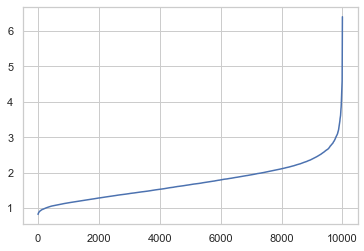

In [38]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
df = pd.DataFrame(RobustScaler().fit_transform(data), columns=data.columns, index = data.index)
neigh.fit(df)
distances, _ = neigh.kneighbors(df)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [39]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=3.5, min_samples=40, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


<AxesSubplot:ylabel='count'>

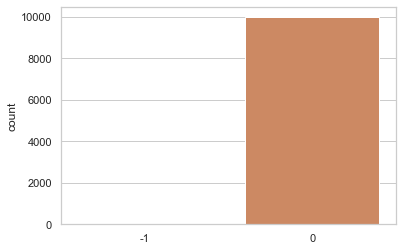

In [40]:
# Concatenating the labels to df
sns.countplot(dbscan_labels)

In [41]:
# the observations identified as outliers are the ones with labels = -1 
# dispaying the outliers detected
print('Number of outliers detected by DBSCAN :', np.sum(dbscan_labels == -1))

Number of outliers detected by DBSCAN : 21


In [29]:
# dropping the outliers and storing the result in df_clean
#df_clean = df_dbscan[~df_dbscan['dbscan_labels'] == -1].drop(columns=['dbscan_labels'])

Since the number of outliers is not significant and we already treated them using the box-cox transfromation, we will not consider to drop them in this analysis

# 4. Clusters analysis <a class="anchor" id="4"></a>

### SOM for visualizations of the dimensional space

Performing now the Self Organizing Maps algorithm in order to better understand the high-dimensional space of the dataset we're working with

In [42]:
df

Dayswus       Age       Edu    Income  Kidhome  Teenhome  Freq  \
Custid                                                                    
5325   -0.688080  0.233333  1.000000  0.190113      0.0       0.0  0.40   
3956    0.419700  0.900000  0.333333  0.788114      0.0       0.0  1.20   
3681   -0.650964 -1.000000 -1.666667 -0.944343      1.0       0.0 -0.40   
2829    0.442541 -0.200000 -0.333333 -0.185687      1.0       1.0 -0.50   
8788   -0.162741 -0.033333 -0.333333 -0.094888      0.0       1.0 -0.50   
...          ...       ...       ...       ...      ...       ...   ...   
1383    0.679515  0.300000  1.000000  0.247635      0.0       1.0  0.35   
4070   -0.850821  0.600000 -0.666667  0.330345      0.0       0.0  0.30   
7909   -0.785153 -1.000000 -1.666667 -0.663880      0.0       0.0 -0.45   
4158    0.608137 -0.500000 -0.333333 -0.367397      1.0       0.0 -0.55   
4914    0.242684  0.233333 -0.333333  0.559802      0.0       1.0  0.65   

         Recency  Monetary       LTV  ...  WebVisit  SMRack  LGRack  Humid  \
Custid                                ...                                    
5325   -0.650718  0.436884  1.060109  ...     -0.25     0.0     0.0    0.0   
3956   -0.363636  1.448718  1.316940  ...     -0.50     0.0     0.0    0.0   
3681    0.076555 -0.339250 -0.174863  ...      0.50     0.0     0.0    0.0   
2829   -0.114833 -0.341223 -0.172131  ...      0.25     0.0     0.0    0.0   
8788   -0.937799 -0.342209 -0.144809  ...      0.00     0.0     0.0    0.0   
...          ...       ...       ...  ...       ...     ...     ...    ...   
1383    0.133971  0.387574  0.355191  ...     -0.50     1.0     0.0    0.0   
4070   -0.133971  0.332347  0.912568  ...     -1.00     0.0     0.0    0.0   
7909    0.248804 -0.331361 -0.142077  ...     -0.25     0.0     0.0    0.0   
4158    6.047847 -0.362919 -0.150273  ...      0.00     0.0     0.0    0.0   
4914   -0.459330  0.754438  0.644809  ...     -0.25     0.0     0.0    0.0   

        Spcork  Bucket  Access  Complain  Mailfriend  Emailfriend  
Custid                                                             
5325       0.0     0.0     0.0       0.0         0.0          0.0  
3956       1.0     0.0     0.0       0.0         0.0          0.0  
3681       0.0     0.0     0.0       0.0         0.0          0.0  
2829       0.0     0.0     0.0       0.0         1.0          1.0  
8788       0.0     0.0     0.0       0.0         0.0          0.0  
...        ...     ...     ...       ...         ...          ...  
1383       0.0     0.0     1.0       0.0         1.0          0.0  
4070       0.0     0.0     0.0       0.0         0.0          0.0  
7909       0.0     0.0     0.0       0.0         0.0          0.0  
4158       0.0     0.0     0.0       0.0         0.0          0.0  
4914       0.0     0.0     0.0       0.0         0.0          0.0  

[10000 rows x 28 columns]

In [45]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(500)

sm = sompy.SOMFactory().build(
    df.values, 
    mapsize=(15, 15),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=df.columns
)
sm.train(n_job=4, verbose=None, train_rough_len=100, train_finetune_len=100)

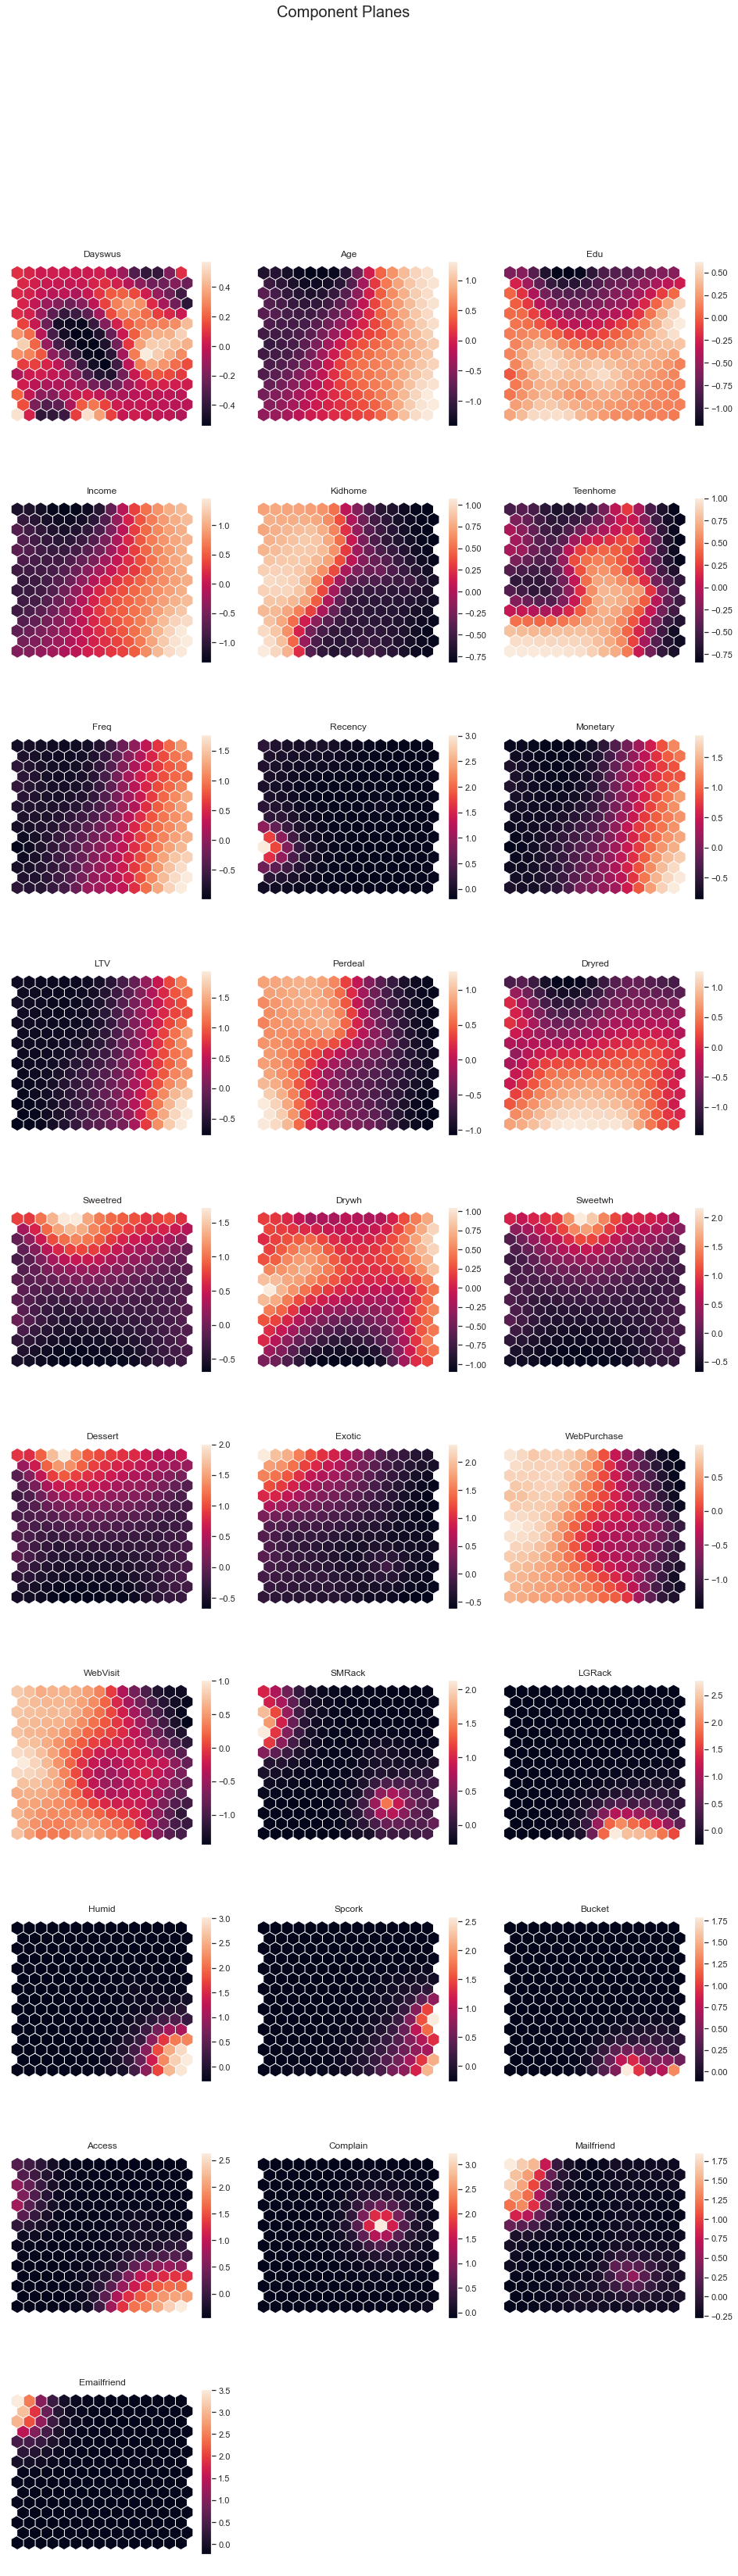

In [46]:
# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

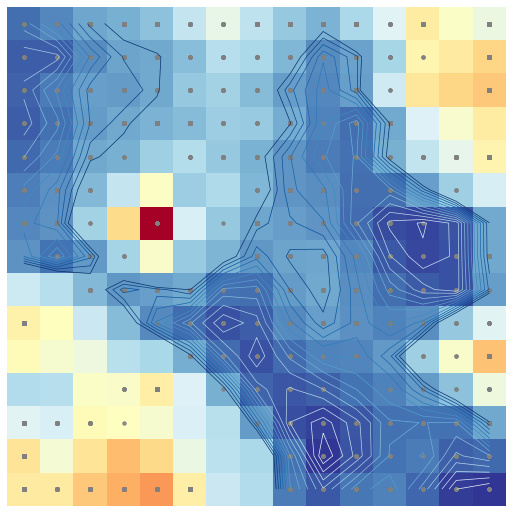

In [47]:
# U-matrix
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)
UMAT = u.show(sm, 
                distance2=1, 
                row_normalized=False, 
                show_data=True, 
                contooor=True, # Visualize isomorphic curves
                blob=False)

### K-means clustering

In [106]:
def inertia_plot(data, range_clusters = range(1, 7), seed = 22):
    inertia = []
    for n_clus in range_clusters:  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=seed)
        kmclust.fit(data)
        inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    sns.set_style("whitegrid")
    # The inertia plot
    plt.figure(figsize=(9,7))
    plt.plot(range(1, len(inertia)+1), inertia, '-o', color='black')
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()
def scaler(data, scaler = StandardScaler()):
    return pd.DataFrame(scaler.fit_transform(data),index = data.index, columns=data.columns)
def kmeans_model(data, n_clusters=3, name = 'km_labels',seed = 22):
    # Better initialization method and provide more n_init
    kmclust = KMeans(n_clusters=n_clusters, init='k-means++', n_init=15, random_state=seed)
    kmclust.fit(data)
    # the predict method
    labels = kmclust.predict(data)
    df_concat_km = pd.concat([data, pd.Series(labels, index=data.index, name=name)], axis=1)
    return df_concat_km, labels
# Function to plot boxplot for each features based on clusters
def boxplot_withLabels(df, labels):
    # Concatenate the dataframe with the labels
    df_concat = pd.concat((df, pd.Series(labels, name='labels', index = df.index)), axis=1)
    # Set up figure
    rows = math.ceil(df.shape[1]/4)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(rows,4, constrained_layout=False, figsize=(24,5*rows))
    fig.suptitle("Box plot for each features\n", fontsize=25)
    # Draw nested boxplots
    for col, ax in zip(df.columns, axes.flatten()):
        sns.boxplot(x='labels', y=col, data=df_concat, ax=ax )
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x',labelsize = 'large') 
        ax.set_title(col,fontsize = 15)  
    fig.subplots_adjust(hspace=0.3)
    plt.show()
def meanplot_df(df, labels):
    df_concat = pd.concat((df, pd.Series(labels, name='labels',index = df.index)), axis=1)
    plot_data = df_concat.groupby('labels').mean()
    sns.set_style("whitegrid")
    # Plot PCA data
    fig, ax = plt.subplots(figsize = (24,12))
    ax = sns.lineplot(data = plot_data.T,dashes = False)
    plt.xticks(rotation=45)
    plt.show()  
    
    
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color
    
class PCA_combined(object):
    def __init__(self, df):
        self.df = df
        self.n_components = df.shape[1]
        self.pca_model = PCA(n_components = df.shape[1])

    def Explained_variance(self):
        pca = PCA()
        pca_feat = pca.fit_transform(self.df)
        metrics = pd.DataFrame(
                                {"Eigenvalue": pca.explained_variance_,
                                "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
                                "Proportion": pca.explained_variance_ratio_,
                                "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
                                index=range(1, pca.n_components_ + 1))
        return metrics

    def PCA_test(self, n_components):
        self.pca_model = PCA(n_components = n_components)
        pca_feat = self.pca_model.fit_transform(self.df)
        self.pca_feat_names = [f"PC{i}" for i in range(self.pca_model.n_components_)]
        self.pca_df_ = pd.DataFrame(pca_feat, index=self.df.index, columns=self.pca_feat_names)  # remember index=df_pca.index
        #Concat to the original value
        self.concat_pca_df_ = pd.concat([self.df, self.pca_df_], axis=1)
        

    def corr_PCA(self):
        loadings = self.concat_pca_df_.corr().loc[self.df.columns, self.pca_feat_names]
        return loadings
    
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
   
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    This function calculates the silhouette coefficient for each observation according to a clustering solution and then builds the 
    Silhouette plots for a given range of cluster solutions. This is useful to find out the most appropriate number of clusters.
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))  
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # in case we want to seed the silhouette for just one cluster solution
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        # Get parameter that defines number of clusters
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Estimator has no parameter to define number of clusters")
            return None
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # The silhouette coefficient can range from -1, 1
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # initialize y_lower
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title("{} Clusters".format(n_clusters), fontsize=13)
        ax.set_xlabel("Silhouette Coefficients")
        ax.set_ylabel("Cluster Labels")
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette") # The vertical line for average silhouette score of all the values
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Average Silhouette = {0:.2f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Clustering Silhouette Plots"), fontsize=23, fontweight='bold')
    plt.show()

Since `Freq` and `Income` are highly correlated with `LTV` and we already have `avr_purchase` to represent the information in these 2 features, we will drop them as we think they are redundant in any further analysis

In [63]:
# Define numeric and categorical features
cat_feats = ['Kidhome', 'Teenhome', 'SMRack', 'LGRack','Humid', 'Spcork', 'Bucket','Complain', 'Mailfriend', 'Emailfriend', 'Access']
numeric_feats = data.columns[~data.columns.isin(cat_feats)].drop(['Monetary','Freq'],errors = 'ignore')

transform_feats = numeric_feats[~numeric_feats.isin(['LTV'])]
df = pd.concat([box_cox(data[transform_feats],transform_feats), data[['LTV']]], axis = 1)

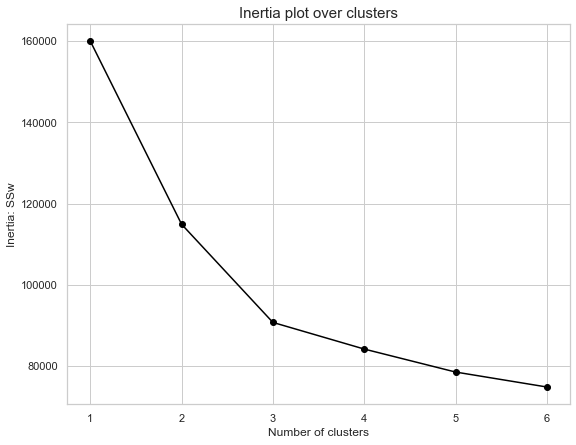

In [67]:
df = scaler(df)
inertia_plot(df)

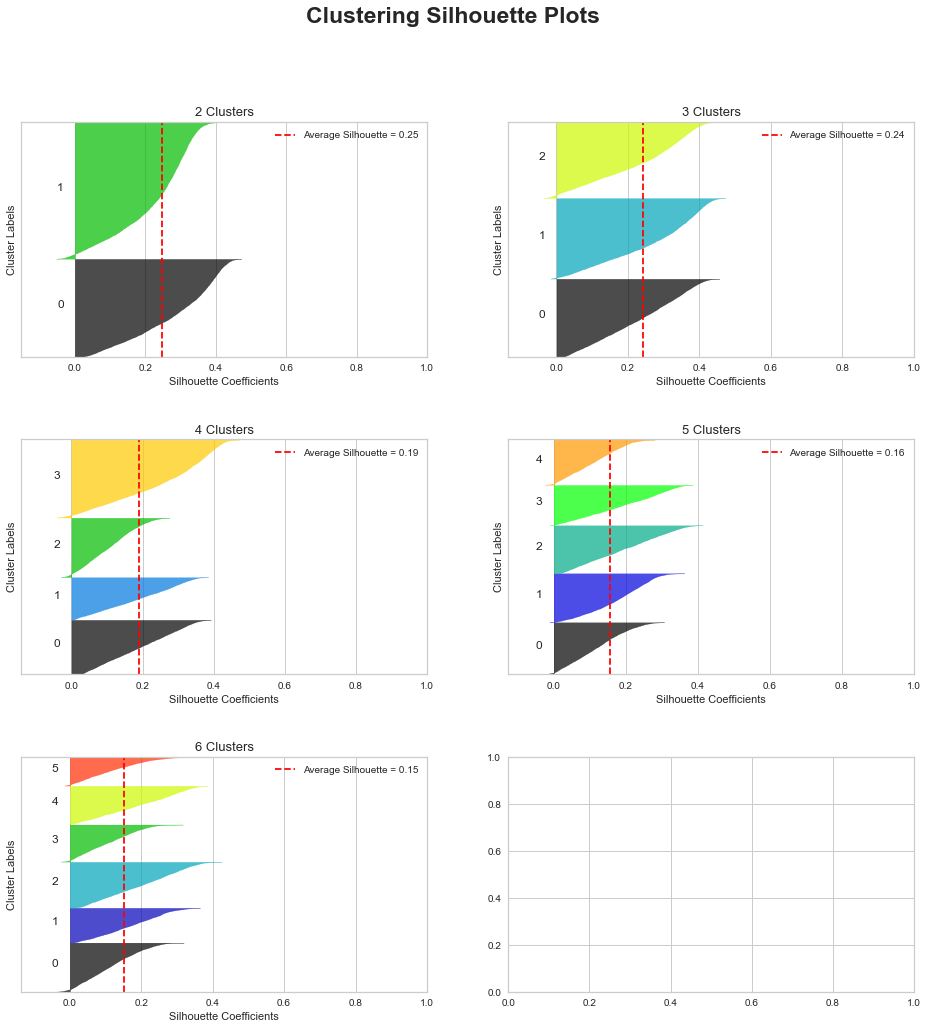

In [109]:
kmeans_model = KMeans(n_init=10, max_iter=300, tol=0.001)
# PLot silhouette coefficence score
silhouette_analysis(df, estimator = kmeans_model, shape = (3,2), figsize = (16,16), max_nclus = 6, min_nclus=2, dist="euclidean")

Lets go with number of clusters = 3

In [68]:
df_clustered, labels = kmeans_model(df,seed = 22)

In [69]:
# Get R2 score of final cluster solution
print('R2 score of the "KMeans" cluster solution:',
      r2(df_clustered.iloc[:,:-1],labels))

print('Silhouette score of the model:', 
      silhouette_score(df_clustered.iloc[:,:-1],labels))

R2 score of the "KMeans" cluster solution: 0.43282854775402224
Silhouette score of the model: 0.24188778687164686


<AxesSubplot:ylabel='count'>

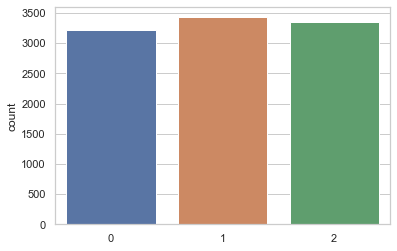

In [70]:
sns.countplot(labels)

In [71]:
pca_combined = PCA_combined(df)
pca_combined.PCA_test(n_components = 4)
pca_combined.corr_PCA().style.applymap(_color_red_or_green)

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

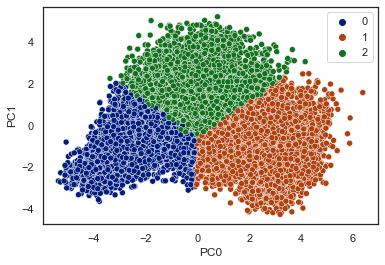

In [72]:
sns.set_style("white")
sns.scatterplot(x='PC0',
                y='PC1',
                data=pca_combined.pca_df_,
                palette="dark",
                hue = labels)

## Profiling the clusters

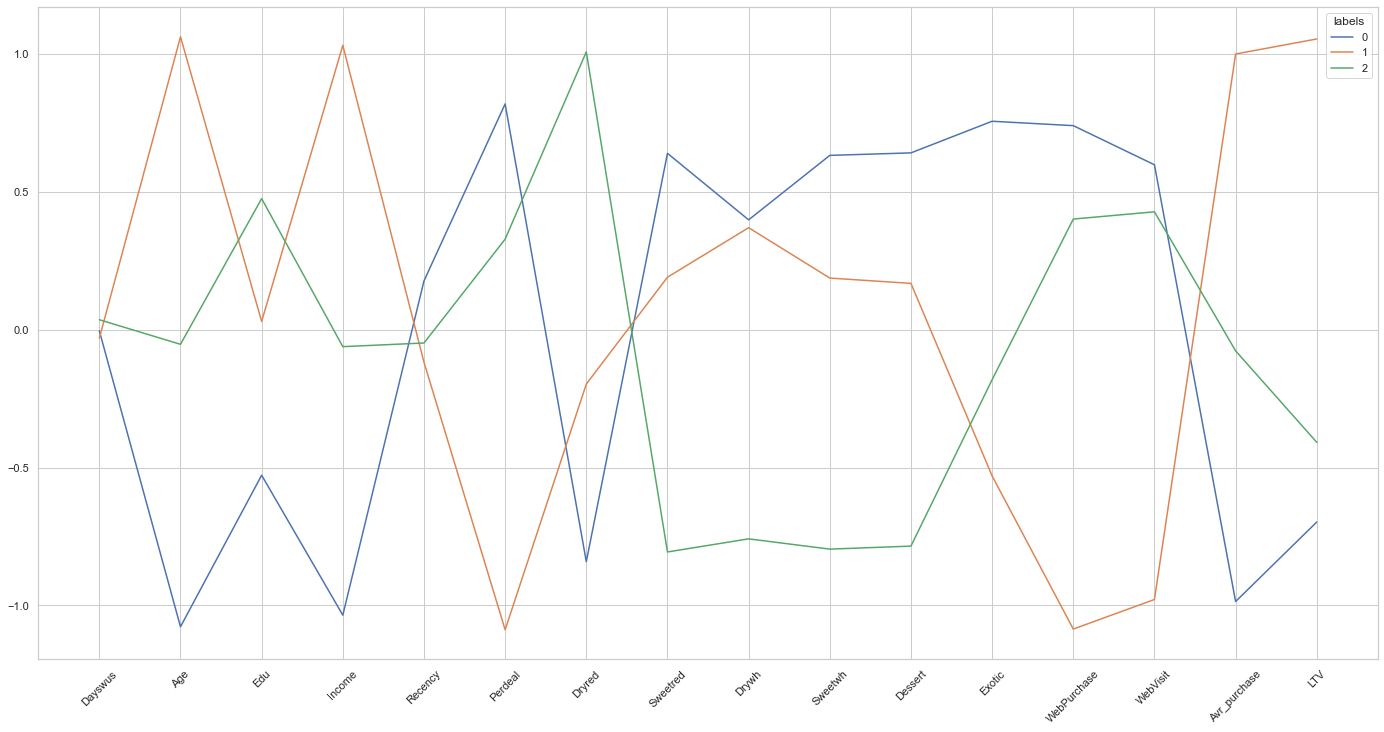

In [73]:
meanplot_df(df_clustered.iloc[:,:-1], df_clustered.iloc[:,-1])

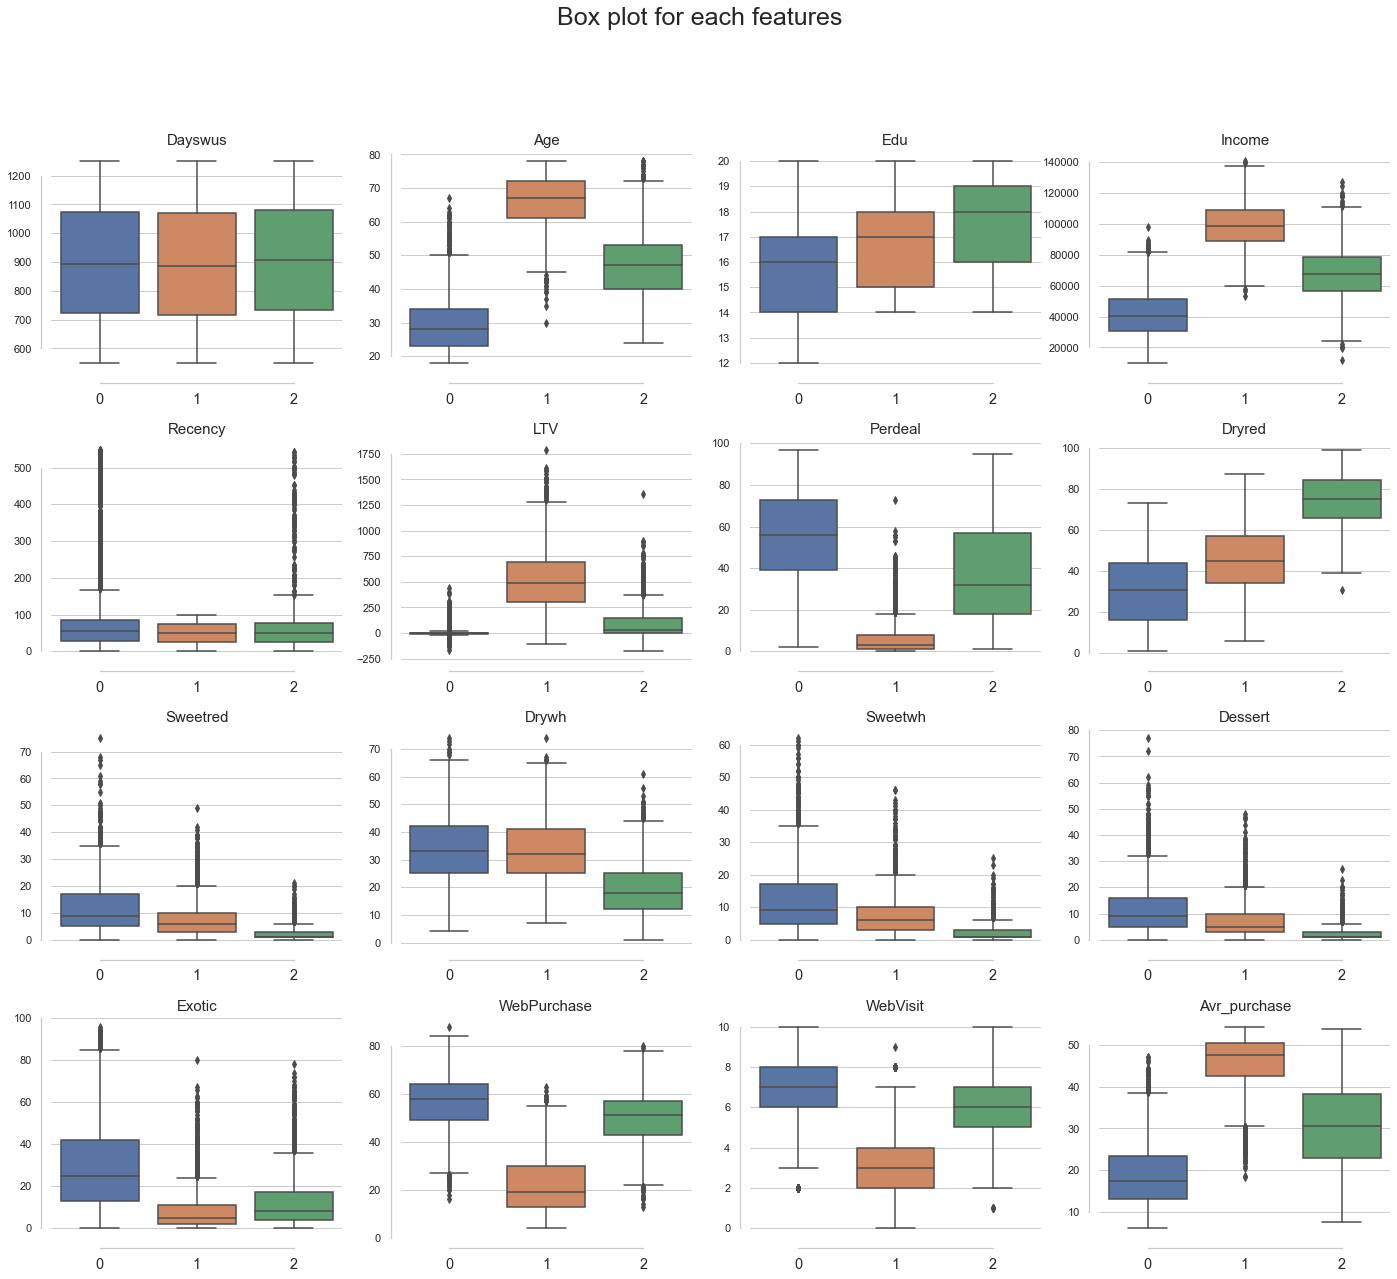

In [26]:
boxplot_withLabels(data[numeric_feats],labels)

### Notations
- The 3 clusters are balanced, and contain between 3000 and 3500 customers 
- Number of days as a customer seems to be not relevant

In [74]:
clusters=pd.concat([data, df_clustered['km_labels']], axis=1)

<AxesSubplot:xlabel='Age', ylabel='Density'>

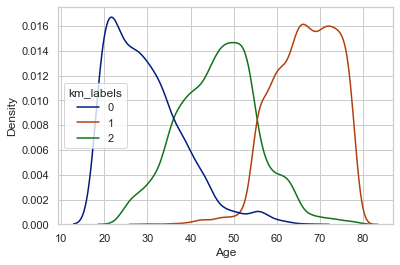

In [77]:
# distribution of age by clusters
sns.kdeplot(data=clusters, 
             x="Age", hue="km_labels",
             palette="dark")

<AxesSubplot:xlabel='Dryred', ylabel='Density'>

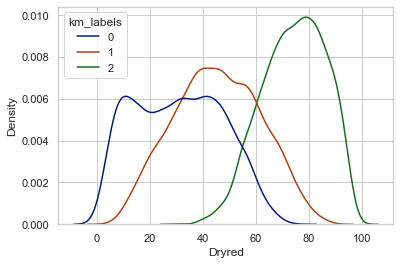

In [78]:
# distribution of age by clusters
sns.kdeplot(data=clusters, 
             x="Dryred", hue="km_labels",
             palette="dark")

## Interpretation of the clusters
 
<font size=4 color='blue'>**Cluster 0: "The Wine Explorer"** </font>
 - **Characteristics**
     - young customers
     - low education
     - low income
     - low frequency
     - higher recency
     - discount-interested
     - good web-user
     - low LTV
     - low accessories
     - young kids at home
 - **Product** 
     - sweet red 
     - sweet white  
     - dessert and 
     - exotic wines 
     - (no dry wine)
 - **Marketing**
     - social media marketing
     - discounts like 2x3

<font size=4 color='orange'>**Cluster 1: "The Wine Expert"** </font>
 - **Characteristics**
     - old customers
     - middle education
     - high income
     - high frequency
     - low recency
     - no discount-interested
     - no web-user
     - very high LTV
     - received some accessories
     - bought some accessories (especially humidifier)
 - **Product** 
     - sweet red wine
     - white wine
     - dessert wine 
     - few dry wine
 - **Marketing**
     - reach them by mail
     - wine-tasting event for the vip customers
     - loyalty card
     
<font size=4 color='green'>**Cluster 2: "The Red Lover"** </font>
 - **Characteristics**
     - middle age
     - higher education
     - middle income (normal)
     - Deals preferable
     - regular frequency of purchase
     - good percentage web-purchase
     - considerable kids and high number of teenagers at home
 - **Product** 
     - dry red wine
 - **Marketing**
     - collaboration with web-food-company (cheese)
     - promo-code for partner resturant for family dining or take-home orders
     - include rack cross-saling in web-purchase

In [37]:
clusters.groupby('km_labels')[numeric_feats].mean()

Dayswus        Age        Edu        Income    Recency  \
km_labels                                                              
0          897.302738  29.548849  15.746422  41615.843186  80.195706   
1          891.869058  66.601633  16.797317  98776.656751  50.045203   
2          905.233840  46.448019  17.630027  67496.307417  58.002383   

                  LTV    Perdeal     Dryred   Sweetred      Drywh    Sweetwh  \
km_labels                                                                      
0            5.410703  55.107654  30.738955  11.898880  33.470753  12.045115   
1          516.776028   5.836979  45.351123   7.351706  32.975503   7.261301   
2           89.751862  37.784033  74.329163   2.112898  19.232946   2.110813   

             Dessert     Exotic  WebPurchase  WebVisit  Avr_purchase  
km_labels                                                             
0          11.844742  29.485376    56.054138  6.608899     18.551696  
1           7.053952   8.555264    22.233013  2.924176     45.881904  
2           2.149836  12.321716    49.856122  6.225201     30.523995

In [38]:
clusters.groupby('km_labels')[numeric_feats].median()

Dayswus   Age   Edu   Income  Recency    LTV  Perdeal  Dryred  \
km_labels                                                                  
0            892.0  28.0  16.0  40614.5     56.0   -2.0     56.0    31.0   
1            885.0  67.0  17.0  98952.0     51.0  486.0      3.0    45.0   
2            906.0  47.0  18.0  67826.0     51.0   34.0     32.0    75.0   

           Sweetred  Drywh  Sweetwh  Dessert  Exotic  WebPurchase  WebVisit  \
km_labels                                                                     
0               9.0   33.0      9.0      9.0    25.0         58.0       7.0   
1               6.0   32.0      6.0      5.0     5.0         19.0       3.0   
2               1.0   18.0      1.0      1.0     8.0         51.0       6.0   

           Avr_purchase  
km_labels                
0             17.250000  
1             47.555556  
2             30.600000

### Buying Frequency

<AxesSubplot:xlabel='Freq', ylabel='Density'>

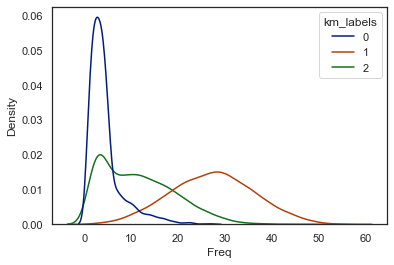

In [41]:
# distribution of age by clusters
sns.kdeplot(data=clusters, 
             x="Freq", hue="km_labels",
             palette="dark")

### Accessories purchases

<AxesSubplot:xlabel='Access', ylabel='count'>

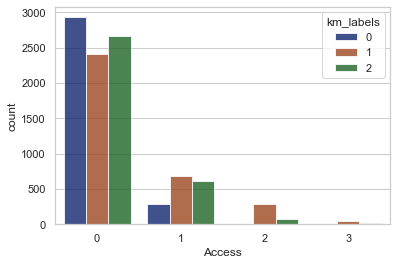

In [82]:
# distribution of age by clusters
sns.countplot(data=clusters, 
             x="Access", hue="km_labels", alpha =.8,
             palette="dark")

### Binary features analysis

In [42]:
binary_feats = cat_feats[:-1]
plot_data = clusters[np.append(binary_feats,"km_labels")].pivot_table(columns="km_labels",aggfunc='sum')

plot_data_go = [dict(type='bar',
             x=plot_data.index,
             y=plot_data[i],
             name="Clusters " + str(i))
                            for i in plot_data.columns]

plot_layout =dict(title=dict(text='Total customers'),
                 yaxis=dict(title='Count'),
                 xaxis=dict(title='Features'),
                 template='plotly_white',
                 barmode='group' # It is in the layout that we define the barmode to stacked, by default is as 'group'
                 )

fig = go.Figure(data=plot_data_go, layout=plot_layout)

fig.show()

### Radar plot for major features

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, n_ordinate_levels=5):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

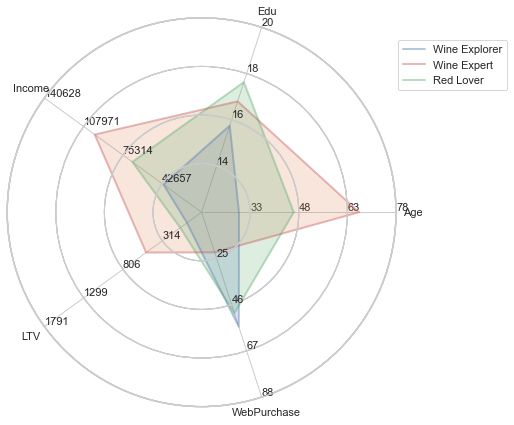

In [95]:
variables = ['Age', 'Edu', 'Income', 'LTV','WebPurchase']
radar_df = clusters.groupby('km_labels')[variables].mean()
radar_df.iloc[0]        
        
# example data
#titles = ['Age', 'Edu', 'Income', 'LTV','Avr_purchase']

data0 = radar_df.iloc[0]
data1 = radar_df.iloc[1]
data2 = radar_df.iloc[2]

ranges = [(clusters[feat].min(), clusters[feat].max()) for feat in variables]          
# plotting
fig1 = plt.figure(figsize=(6, 6))

radar = ComplexRadar(fig1, variables, ranges)

radar.plot(data0, "-", lw=2, color="b", alpha=0.4, label="Wine Explorer")
radar.plot(data1, "-", lw=2, color="r", alpha=0.4, label="Wine Expert")
radar.plot(data2, "-", lw=2, color="g", alpha=0.4, label="Red Lover")

radar.fill(data0, alpha=0.2)
radar.fill(data1, alpha=0.2)
radar.fill(data2, alpha=0.2)
radar.ax.legend(loc = 'lower right', bbox_to_anchor=(1.3, 0.8))
plt.show()  

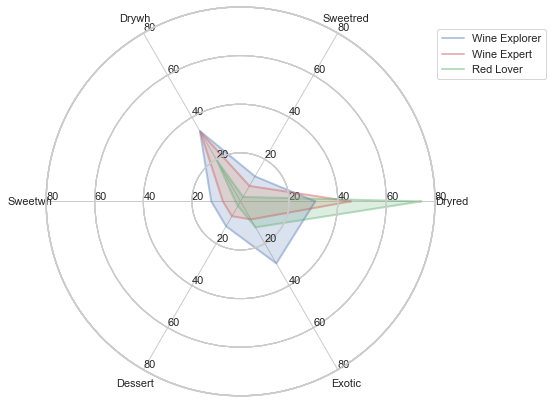

In [96]:
variables = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh','Dessert','Exotic']
radar_df = clusters.groupby('km_labels')[variables].mean()
radar_df.iloc[0]        
        
# example data

# example data
#titles = ['Age', 'Edu', 'Income', 'LTV','Avr_purchase']

data0 = radar_df.iloc[0]
data1 = radar_df.iloc[1]
data2 = radar_df.iloc[2]
ranges = [(0, 80) for feat in variables]          
# plotting
fig1 = plt.figure(figsize=(6, 6))

radar = ComplexRadar(fig1, variables, ranges)

radar.plot(data0, "-", lw=2, color="b", alpha=0.4, label="Wine Explorer")
radar.plot(data1, "-", lw=2, color="r", alpha=0.4, label="Wine Expert")
radar.plot(data2, "-", lw=2, color="g", alpha=0.4, label="Red Lover")

radar.fill(data0, alpha=0.2)
radar.fill(data1, alpha=0.2)
radar.fill(data2, alpha=0.2)
radar.ax.legend(loc = 'lower right', bbox_to_anchor=(1.3, 0.8))
plt.show()  

### Feature importance:

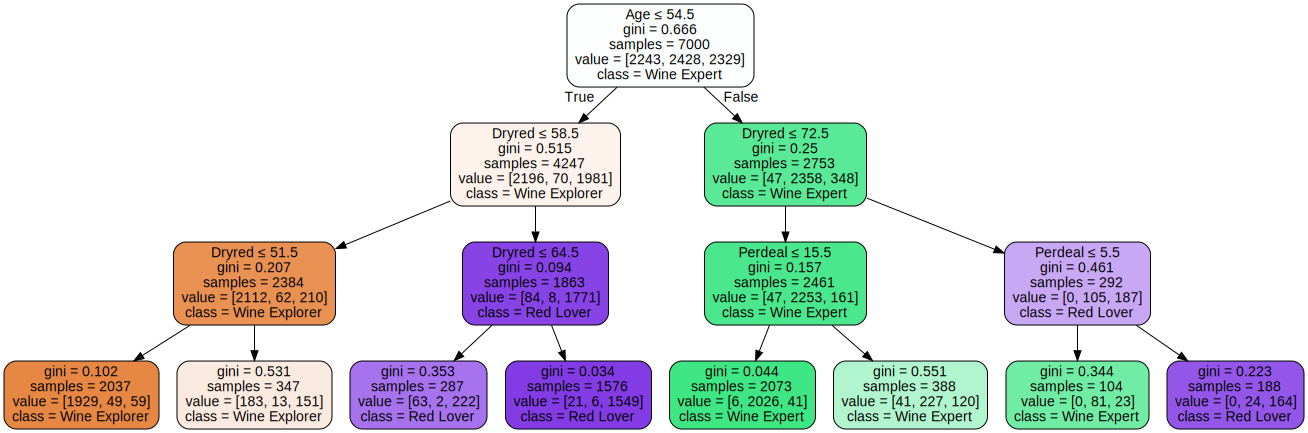

In [120]:
# Dependent and Independent Variable
X = clusters.iloc[:,:-2]
y = clusters.iloc[:,-1] # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X.columns.to_list(),
                           class_names=["Wine Explorer","Wine Expert","Red Lover"],
                           filled=True,
                           rounded=True,
                           special_characters=True)  
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
#fig, ax = plt.subplots(figsize=(20, 10))
#plot_tree(clf, filled=True, ax=ax)
# plt.savefig("fig.png")

In [121]:
# Test accuracy
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(clf.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 91.10% of the customers correctly


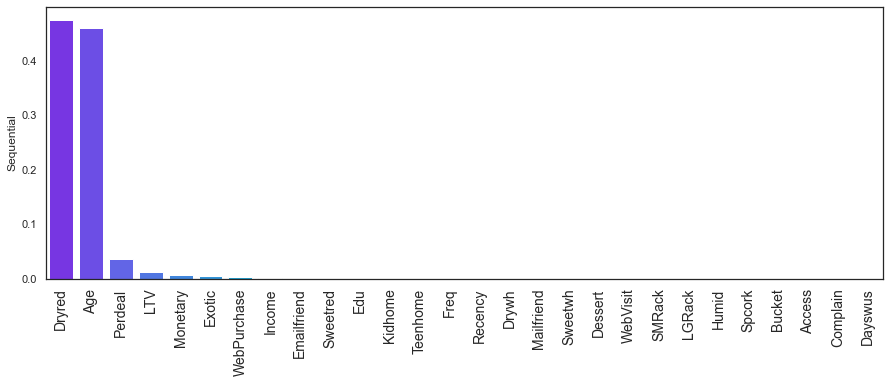

In [54]:
feats_imp = pd.Series(data = clf.feature_importances_,index = X.columns)
feats_imp.sort_values(ascending=False,inplace=True)

fig,ax = plt.subplots(figsize=(15, 5), sharex=True)
# Generate some sequential data
sns.barplot(y=feats_imp.values, x= feats_imp.index, palette="rainbow", ax=ax,)
ax.set_ylabel("Sequential")
plt.xticks(rotation=90, fontsize = 14)
plt.show()

`Dryred` adn `Age` are the most significant features in this segmentation. 

Besides the classification of the outliers, the decision tree classifier provides a set of simple rules that allow future customer classification into each cluster by performing some simple queries. Below, it is illustrated what are the questions necessary to classify a customer into each cluster:

- <font color = blue> **Wine Explorer** </font>: If a customer has `Age` ≤ 54.5 and `Dryred` ≤ 51.5 then the customer belongs to this cluster with a **94.7% probability**;
- <font color = red> **Wine Expert** </font>: If a customer has `Age` > 54.5, `Dryred` ≤ 72.5 and `Perdeal` ≤ 15.5 then the customer belongs to this cluster with a **97.68% probability**;
- <font color = green> **Red Lover** </font>:  If a customer has `Age` ≤ 54.5 and `Dryred` > 58.5 then the customer belongs to this cluster with a **94.81% probability**;

With this set of rules we can easily filter our database to classify customers that weren't present in the sample provided as well as future customers. It is possible to see that we only need to access the values of the motor_prop, health_prop and t_premiums_salary variables in order to classify the customers. This is also an indicative that the clusters ared defined mainly by these three variables. This matches the findings in the Customer segmentation that the variables used didn't provide a lot of discriminance.

To be more practical in the deployment of the model, we also build an API to test the model prediction on new customer to know which cluster they belong to

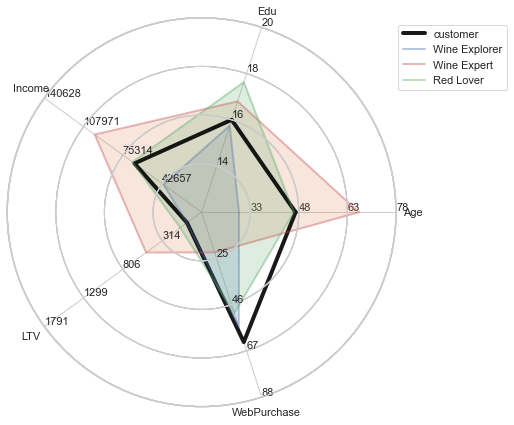

In [105]:
variables = ['Age', 'Edu', 'Income', 'LTV', 'WebPurchase']

radar_df = clusters.groupby('km_labels')[variables].mean()
radar_df.iloc[0]        
        
# example data
#titles = ['Age', 'Edu', 'Income', 'LTV','Avr_purchase']

data0 = radar_df.iloc[0]
data1 = radar_df.iloc[1]
data2 = radar_df.iloc[2]
data_customer = data.iloc[4,:-2].values[data.iloc[4,:-2].index.isin(variables)]

ranges = [(clusters[feat].min(), clusters[feat].max()) for feat in variables]          
# plotting
fig1 = plt.figure(figsize=(6, 6))

radar = ComplexRadar(fig1, variables, ranges)


radar.plot(data_customer, "-", lw=4, color="black", alpha=0.9, label="customer")

radar.plot(data0, "-", lw=2, color="b", alpha=0.4, label="Wine Explorer")
radar.plot(data1, "-", lw=2, color="r", alpha=0.4, label="Wine Expert")
radar.plot(data2, "-", lw=2, color="g", alpha=0.4, label="Red Lover")

radar.fill(data0, alpha=0.2)
radar.fill(data1, alpha=0.2)
radar.fill(data2, alpha=0.2)
radar.ax.legend(loc = 'lower right', bbox_to_anchor=(1.3, 0.8))
plt.show()  

In [61]:
test_id = 22

out_path = os.path.join(PROJECT_ROOT, 'analysis')
# Saving best model
best_dt = clf
dump(best_dt, os.path.join(out_path, 'best_decision_tree{}.joblib'.format(test_id)))

['C:\\Users\\Admin\\Documents\\0.DSAA2020\\Jupyter Notebook\\Business Case\\Case 1\\analysis\\best_decision_tree22.joblib']

## Evaluation:

### Evaluate results
The proposed model (K-means clustering) has performed a good result in both clusters size and R2 score, which tell that the models is good in classify different customer segments. The defined clusters show distinctive values in most of the features.

For better understanding the clusters, a decision tree model is created to re-classify the dataset. The prediction result on testset (30% of the dataset) is 93% which is a very good result. 

Features importance are measured and the two features showing huge discriminative ability is `Dryed` and `Age`, follow by less significant features such as `Perdeal`, `LTV` and `Avr_purchase`.

### Review process
Major steps conducted in the project:
- Feature engineering: `Avr_purchase` = `Monetary` / `Freq`
- Data transformation: Box-cox transformation
- Data normalization: Standard scaler
- Clustering: K-means algorithm
- Classification/ Predictive model: Decision Tree Classifier

All the steps are conducted successfully and contribute to the final result

We will proceed to deploy the proposed model as it already satisfies the business goals and the data mining goals.

## Deployment:
Deployment is a crucial part of every business project. A machine learning model will not be able to drive values if it is not effectively deployed in the real-world context.


### Plan deployment
The dataset collected by IT department is in a very good condition as no missing value and data error was found during the exploratory process. However, to ensure the quality of the predictive model in future use as well as scalability of the clustering model if there are more data fed in, any newly collected data should have the same quality as the current one.

To test the deployment, we also create an API to predict the belonging cluster of any new customer.

[**Test on API**]
- "Wine Explorer": `1049,42,16,61748,1,1,2,46,37,-6,70,86,1,11,1,1,55,59,7,0,0,0,0,0,0,0,1,1`
- "Wine Expert": `666,18,12,27984,1,0,4,56,39,-7,88,4,29,14,32,21,48,60,8,0,0,0,0,0,0,0,0,0`
- "Red Lover": `653,55,20,78473,0,0,20,18,826,445,7,67,4,26,2,1,1,36,5,0,0,0,0,0,0,0,0,0`

### Plan monitoring and maintenance
ML models can have reduced performance not only due to suboptimal coding, but also due to constantly evolving data profiles. In other words, models can decay in more ways than conventional software systems, and we need to consider this degradation. Therefore, we need to **track summary statistics of the data and monitor the online performance of the model** to send notifications or roll back when values deviate from what we expect (**data shifts**). When this happens, a new experimentation iteration and retraining of the model on new data occurs in order to adapt to the changes in the data.

CT is implemented by automating the ML pipeline to **retrain the models based on defined triggers**. These triggers should be activated on a defined schedule, on model performance degradation and on significant changes in the data distributions.

### Produce final report and presentation
\[Not developed in this example.\]

### Review project
\[**Note**: This part should be developed closely with the stakeholders to understand what went right and what went wrong and what needs to be improved. Also you should summarize important experience gained during the project.\]